# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# План работ:

1. Загрузить и изучить данные. 
2. Заполнить пропущенные значения и обработать аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.
2. Подготовить выборки для обучения моделей.
4. Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.
5. Проанализировать время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

# Описание данных:

- Признаки
    - DateCrawled — дата скачивания анкеты из базы
    - VehicleType — тип автомобильного кузова
    - RegistrationYear — год регистрации автомобиля
    - Gearbox — тип коробки передач
    - Power — мощность (л. с.)
    - Model — модель автомобиля
    - Kilometer — пробег (км)
    - RegistrationMonth — месяц регистрации автомобиля
    - FuelType — тип топлива
    - Brand — марка автомобиля
    - Repaired — была машина в ремонте или нет
    - DateCreated — дата создания анкеты
    - NumberOfPictures — количество фотографий автомобиля
    - PostalCode — почтовый индекс владельца анкеты (пользователя)
    - LastSeen — дата последней активности пользователя
- Целевой признак
    - Price — цена (евро)

## Подготовка данных

### Подключим необходимые библиотеки и настройки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import time
#from datetime import datetime

!pip install lightgbm
!pip install catboost

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_colwidth', 1000)

RANDOM_STATE = 42

You should consider upgrading via the 'C:\Users\MSI-\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\MSI-\anaconda3\python.exe -m pip install --upgrade pip' command.


**Создадим и применим функцию функцию, которая будет на вход принимать датафрейм, а на выходе будет выводить все необходимые характеристики поочередно применяя методы:**

In [2]:
def data_info(dataframe):
    print('Выведем общую информацию по датафрейму:')
    display(dataframe.info())
    print('\nВыведем первые 10 строк:')
    display(dataframe.head(10))
    print('\nВыведем последние 10 строк:')
    display(dataframe.tail(10))
    print('\nПосмотрим пропуски:')
    display(dataframe.isnull().sum().sort_values(ascending=False))
    print('\nПосмотрим на описание датафрейма:')
    display(dataframe.describe())
    print('\nКоличество дубликатов:')
    display(dataframe.duplicated().sum())
    print('\nПосмотрим на признаки:\n')
    num_columns, cat_columns = [], []
    for num, i in enumerate(dataframe.columns):
        if pd.api.types.is_numeric_dtype(dataframe[i]):
            print(
                f'{num+1}. {i} - тип данных int64, уникальных значений: {len(dataframe[i].unique())}')
            num_columns.append(i)
        elif pd.api.types.is_object_dtype(dataframe[i]):
            print(
                f'{num+1}. {i} - тип данных object, уникальных значений: {len(dataframe[i].unique())}')
            cat_columns.append(i)
    print(
        f'\nИтого:\nпризнаки с типом данных int64: {len(num_columns)}\nпризнаки с типом данных object: {len(cat_columns)}')
#     fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
#     fig.suptitle('Распределение значений признаков', fontsize=20)
#     for num, col_name in enumerate(dataframe.columns):
#         row = num // 4
#         col = num % 4
#         if dataframe[col_name].nunique() > 10000:
#             ax[row][col].set_title(col_name)
#             ax[row][col].set_xticks([])
#             ax[row][col].set_yticks([])
#             continue
#         if col_name in num_columns:
#             ax[row][col].hist(dataframe[col_name].dropna(), bins=20)
#             ax[row][col].set_title(col_name)
#             ax[row][col].set_xticks([])
#             ax[row][col].set_yticks([])
#         else:
#             counts = dataframe[col_name].dropna().value_counts()
#             ax[row][col].pie(counts.values.tolist(), startangle=90, wedgeprops={
#                              'linewidth': .5, 'edgecolor': 'white'})
#             ax[row][col].set_title(col_name)
#     plt.subplots_adjust(hspace=.8, wspace=.5)
#     plt.show

### Загрузим и опишем датафрейм:

In [3]:
# try:
#     data = pd.read_csv('D:\\Profile\\Desktop\\Ya_P\\Python\\Projects\\data\\autos.csv')
# except FileNotFoundError:
#     data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [4]:
path_1 = '_______________autos.csv'
path_2 = 'https://____________autos.csv'

if os.path.exists(path_1):
    data = pd.read_csv(path_1)
elif os.path.exists(path_2):
    data = pd.read_csv(path_2)
else:
    print('Что-то пошло не так')

In [5]:
data_info(data)

Выведем общую информацию по датафрейму:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 no

None


Выведем первые 10 строк:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06



Выведем последние 10 строк:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354359,2016-03-28 13:48:07,7900,sedan,2010,manual,140,golf,150000,7,gasoline,volkswagen,no,2016-03-28 00:00:00,0,75223,2016-04-02 18:16:20
354360,2016-04-02 20:37:03,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02 00:00:00,0,81825,2016-04-06 20:47:12
354361,2016-03-09 13:37:43,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09 00:00:00,0,51371,2016-03-13 01:44:13
354362,2016-03-19 19:53:49,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,2016-03-19 00:00:00,0,96465,2016-03-19 20:44:43
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21



Посмотрим пропуски:


Repaired             71154
VehicleType          37490
FuelType             32895
Gearbox              19833
Model                19705
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


Посмотрим на описание датафрейма:


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Количество дубликатов:


4


Посмотрим на признаки:

1. DateCrawled - тип данных object, уникальных значений: 271174
2. Price - тип данных int64, уникальных значений: 3731
3. VehicleType - тип данных object, уникальных значений: 9
4. RegistrationYear - тип данных int64, уникальных значений: 151
5. Gearbox - тип данных object, уникальных значений: 3
6. Power - тип данных int64, уникальных значений: 712
7. Model - тип данных object, уникальных значений: 251
8. Kilometer - тип данных int64, уникальных значений: 13
9. RegistrationMonth - тип данных int64, уникальных значений: 13
10. FuelType - тип данных object, уникальных значений: 8
11. Brand - тип данных object, уникальных значений: 40
12. Repaired - тип данных object, уникальных значений: 3
13. DateCreated - тип данных object, уникальных значений: 109
14. NumberOfPictures - тип данных int64, уникальных значений: 1
15. PostalCode - тип данных int64, уникальных значений: 8143
16. LastSeen - тип данных object, уникальных значений: 179150

Итого:
признаки с типом дан

**Предварительный вывод:**

- В датафрейме 16 признаков и 354369 наблюдений.
- Названия признаков стоит привести к snake_case
- В 5 признаках присутствуют пропущенные значения - с ними будем разбираться поотдельности
- Обнаружено 4 явных дубликата, стоит их удалить 
- 7 признаков имеют тип данных int64, 9 признаков имеют тип данных object. Проверять их на наличие аномальных значений и значимость для обучения модели определения стоимости автомобиля также будем индивидуально.

### Разберемся с признаками:

In [6]:
# Объявим переменную отображающую исходный размер датафрейма:
original_size = data.shape
original_size

(354369, 16)

#### Приведем к snake_case названия признаков:

In [7]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data.columns]
# Проверим:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

#### Удалим дубликаты:

In [8]:
data.drop_duplicates(inplace=True)
# Проверим:
print(f'Количество дубликатов: {data.duplicated().sum()}')

Количество дубликатов: 0


#### Признак 'number_of_pictures' (количество фотографий автомобиля) 
Признак неинформативен и содержит одно уникальное значение - 0, поэтому удалим его.

In [9]:
data = data.drop(['number_of_pictures'], axis=1)

#### Признаки 'date_crawled' (дата скачивания анкеты из базы), 'date_created' (дата создания анкеты) и 'last_seen' (дата последней активности пользователя)
Приведем их к datetime и посмотрим на них:

In [10]:
# Создадим функцию:

def plot_date_columns(data, date_columns):
    """
    Функция принимает на вход датафрейм и список признаков с датами
    приводит признаки к типу datetime и выводит графики и сводную таблицу по начальным и 
    конечным датам для каждого признака
    """
    min_max_dates = pd.DataFrame(columns=['Признак', 'Начальная дата', 'Конечная дата'])

    for column in date_columns:
        data[column] = pd.to_datetime(data[column])
        min_date = data[column].min()
        max_date = data[column].max()
        min_max_dates = pd.concat([min_max_dates, pd.DataFrame(
            {'Признак': [column], 'Начальная дата': [min_date], 'Конечная дата': [max_date]})])
        plt.figure(figsize=(12, 5))
        data[column].plot(grid=True)
        plt.title(f'Распределение значений по {column}')
        plt.xlabel('Количество наблюдений')
        plt.ylabel(column)
        plt.show()

    return min_max_dates

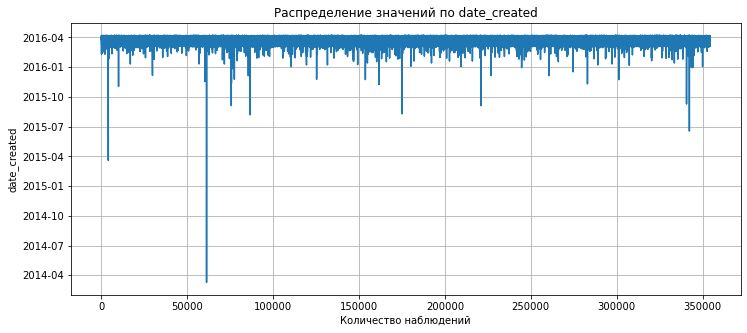

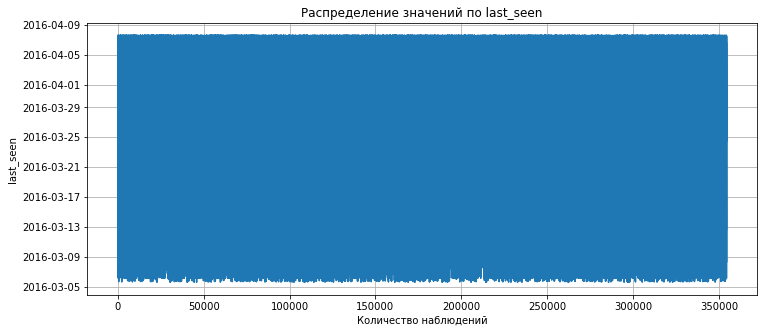

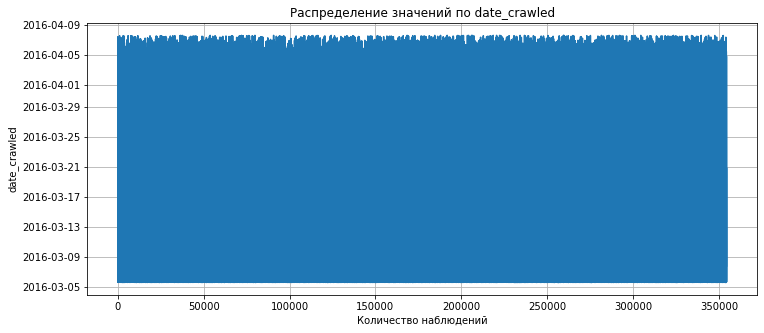

,Признак,Начальная дата,Конечная дата
0,date_created,2014-03-10 00:00:00,2016-04-07 00:00:00
0,last_seen,2016-03-05 14:15:08,2016-04-07 14:58:51
0,date_crawled,2016-03-05 14:06:22,2016-04-07 14:36:58


In [11]:
date_columns = ['date_created', 'last_seen', 'date_crawled']
min_max_dates = plot_date_columns(data, date_columns)
display(min_max_dates)

In [12]:
# Посмотрим на признаки с датами создания анкет в 2014 - 2015 годах:
display(data[data['date_created'].between('2014-01-01', '2015-12-31')
             ].sort_values(by='date_created')[['date_created', 'date_crawled', 'last_seen']])

,date_created,date_crawled,last_seen
61207,2014-03-10,2016-03-16 11:48:06,2016-04-07 04:46:24
4001,2015-03-20,2016-03-23 14:42:46,2016-04-07 03:45:01
342275,2015-06-18,2016-03-05 21:44:26,2016-04-05 17:46:09
86601,2015-08-07,2016-04-02 19:47:40,2016-04-07 09:15:23
175103,2015-08-10,2016-03-08 17:57:45,2016-04-05 20:46:54
75598,2015-09-04,2016-03-14 08:43:53,2016-03-15 14:16:58
221002,2015-09-04,2016-03-15 01:56:49,2016-03-15 15:49:29
340616,2015-09-09,2016-03-05 21:51:02,2016-04-05 17:46:04
9972,2015-11-02,2016-03-05 17:53:53,2016-03-17 15:46:57
161567,2015-11-08,2016-03-05 14:31:01,2016-04-06 23:15:36


- Признак 'date_created' (дата создания анкеты) - выборка охватывает временной период с 10.03.2014 г. по 07.04.2016 г. Основной массив данных относится к первым четырем месяцам 2016 г., небольшая часть относится к 2015 г. Обнаружена одна анкета с датой создания в 2014 г. и датой последней активности в 2016 г. 
- Признак 'date_crawled' (дата скачивания анкеты из базы) - данные равномерно распределены в промежутке с 05.03.2016 по 09.04.2016.
- Признак 'last_seen' (дата последней активности пользователя) - данные, как и в признаке 'date_crawled' (дата скачивания анкеты из базы) равномерно распределены в промежутке с 05.03.2016 по 09.04.2016.
- Вышеупомянутые признаки не влияют на процесс ценообразования и могут помешать нам при обучении модели, поэтому удалим их предварительно отсортировав датафрейм по дате создания анкеты.

In [13]:
# Сортируем:
data = data.sort_values('date_created').reset_index(drop=True)

# Удаляем:
data.drop(columns=date_columns, inplace=True)

# Проверяем:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354365 non-null  int64 
 1   vehicle_type        316875 non-null  object
 2   registration_year   354365 non-null  int64 
 3   gearbox             334532 non-null  object
 4   power               354365 non-null  int64 
 5   model               334660 non-null  object
 6   kilometer           354365 non-null  int64 
 7   registration_month  354365 non-null  int64 
 8   fuel_type           321470 non-null  object
 9   brand               354365 non-null  object
 10  repaired            283211 non-null  object
 11  postal_code         354365 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 32.4+ MB


#### Признаки 'registration_year' (год регистрации автомобиля) и 'registration_month' (месяц регистрации автомобиля)

Посмотрим на 'registration_year'

In [14]:
display('Статистические данные:', data['registration_year'].describe())
display('Уникальные значения:', np.sort(data['registration_year'].unique()))

'Статистические данные:'

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

'Уникальные значения:'

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Судя по уникальным значениям, в датафрейме представлены транспортные средства от колесниц Римской Империи, до межгалактических звездолетов) Но среднее и медианное значения выглядят вполне нормально. [Поскольку первые серийные автомобили появились ориентировочно в 1914 году,](https://translated.turbopages.org/proxy_u/en-ru.ru.90a9f31a-649cebed-afa74bc9-74722d776562/https/en.wikipedia.org/wiki/Production_vehicle#:~:text=%D0%A1%D0%B0%D0%BC%D0%BE%D0%B5%20%D1%80%D0%B0%D0%BD%D0%BD%D0%B5%D0%B5%20%D0%B8%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%20%D1%82%D0%B5%D1%80%D0%BC%D0%B8%D0%BD%D0%B0%20%22%D1%81%D0%B5%D1%80%D0%B8%D0%B9%D0%BD%D1%8B%D0%B9%20%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C%22%20%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D0%BD%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%20%D0%BA%20%D0%BB%D0%B5%D0%B3%D0%BA%D0%BE%D0%B2%D1%8B%D0%BC%20%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8F%D0%BC%2C%20%D0%BE%D0%B1%D0%BD%D0%B0%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%BD%D0%BE%D0%B5%20%D0%BD%D0%B0%20%D1%81%D0%B5%D0%B3%D0%BE%D0%B4%D0%BD%D1%8F%D1%88%D0%BD%D0%B8%D0%B9%20%D0%B4%D0%B5%D0%BD%D1%8C%2C%20%D0%B1%D1%8B%D0%BB%D0%BE%20%D0%B2%20%D0%B0%D0%BC%D0%B5%D1%80%D0%B8%D0%BA%D0%B0%D0%BD%D1%81%D0%BA%D0%BE%D0%B9%20%D1%80%D0%B5%D0%BA%D0%BB%D0%B0%D0%BC%D0%B5%20Regal%20motor%20Car%2C%20%D0%B2%D1%8B%D0%BF%D1%83%D1%89%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%B2%20%D0%B8%D1%8E%D0%BD%D0%B5%201914%20%D0%B3%D0%BE%D0%B4%D0%B0.%5B2%5D) а последняя публикация в выборке датирована 2016-04-07, посмотрим на количество анкет вне этого диапазона и удалим их.

In [15]:
# Смотрим:
print('Количество анкет ранее 1910 года:', len(data[data['registration_year'] < 1910]))
print('Количество анкет позднее 2016 года:',  len(data[data['registration_year'] > 2016]))

# Удаляем:
data = data[(data['registration_year'] >= 1910) & (data['registration_year'] <= 2016)]

# Проверяем:
print('Анкет ранее 1910 года осталось:', len(data[data['registration_year'] < 1910]))
print('Анкет позднее 2016 года осталось:',  len(data[data['registration_year'] > 2016]))

Количество анкет ранее 1910 года: 66
Количество анкет позднее 2016 года: 14530
Анкет ранее 1910 года осталось: 0
Анкет позднее 2016 года осталось: 0


Выведем обновленные статистические данные:

In [16]:
data['registration_year'].describe()

count    339769.000000
mean       2002.482236
std           7.091220
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

Посмотрим на распределение анкет по годам:

In [17]:
def plot_distribution(x, y, xlabel, ylabel, title, rotation=0, h=False):
    """
    Функция принимает следующие параметры:
    x: массив значений на оси X или массив меток для каждого столбца/полосы гистограммы.
    y: массив значений на оси Y, представляющих высоту каждого столбца/полосы гистограммы.
    xlabel: подпись оси X.
    ylabel: подпись оси Y.
    title: заголовок графика.
    rotation (необязательный): угол поворота подписей делений оси X. 
    h (необязательный): указывает, следует ли строить гистограмму вертикально (False) или горизонтально (True).
    Функция отрисовывает столбчатую диаграмму
    """
    
    if h:
        plt.figure(figsize=(15, 8))
        plt.barh(x, y)
        axis_ = 'x'
    else:
        plt.figure(figsize=(15,5))
        plt.bar(x, y)
        axis_ = 'y'
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if len(x) <= 14:
        plt.xticks(range(len(x)), x, rotation=rotation)
    else:
        plt.xticks(rotation=rotation)
    plt.minorticks_on()
    plt.grid(which='major', axis=axis_, linewidth=.5)
    plt.grid(which='minor', axis=axis_, linewidth=.25, linestyle='--')
    
    plt.show()

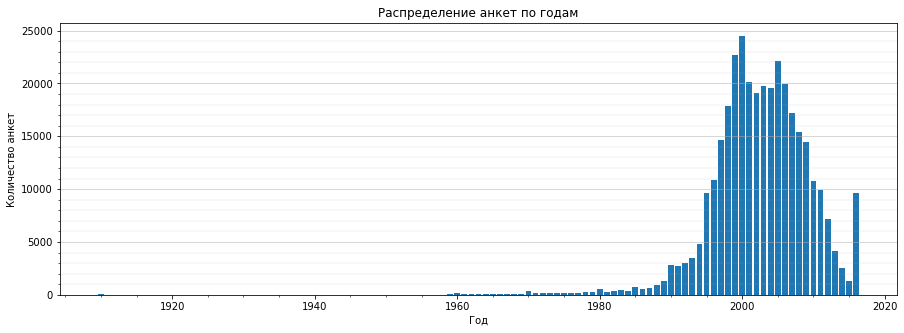

In [18]:
inform_dataset = data['registration_year'].value_counts().sort_index().reset_index()
inform_dataset.columns = ['year', 'count']

plot_distribution(inform_dataset['year'], inform_dataset['count'],
                  'Год', 'Количество анкет', 'Распределение анкет по годам')

Наблюдаем длинный хвост слева, который говорит нам, что фактически регистрация автомобилией в более-менее заметном для нас объеме представлена с 1980-85 годов. Хвост до 1980 года признаем аномальным. Посмотрим на количество анкет в нем и удалим.

In [19]:
print('Анкет ранее 1980 года осталось:', len(data[data['registration_year'] < 1980]))
# Удалим аномальные значения
data = data[data['registration_year'] > 1980]
# Проверим:
print('Анкет ранее 1980 года осталось:', len(data[data['registration_year'] < 1980]))

Анкет ранее 1980 года осталось: 3386
Анкет ранее 1980 года осталось: 0


Посмотрим на обновленное распределение анкет по годам:

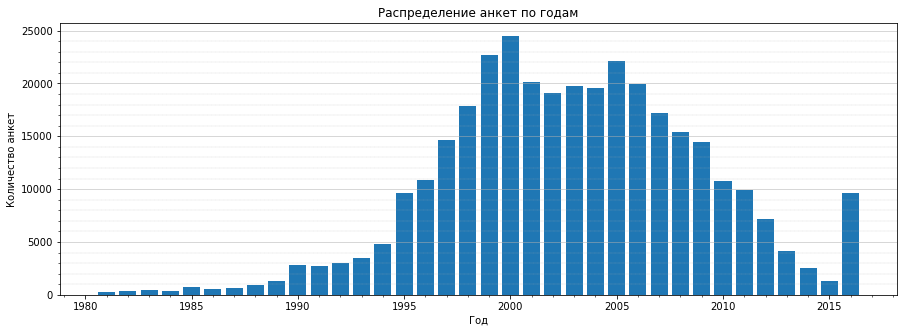

In [20]:
inform_dataset = data['registration_year'].value_counts().sort_index().reset_index()
inform_dataset.columns = ['year', 'count']

plot_distribution(inform_dataset['year'], inform_dataset['count'],
                  'Год', 'Количество анкет', 'Распределение анкет по годам')

Уже вырисовывается нормальное распределение. Но мы наблюдаем всплеск в 2016 году. Причина его возникновения нам неизвестна, возможно имел место быть технический сбой при снятии базы. Мы точно знаем, что выборка охватывает временной период с 10.03.2014 по 07.04.2016 гг. Поэтому данные о регистрации после 07.04.2016 будем считать аномальными. Посмотрим на 'registration_month' (месяц регистрации автомобиля)

In [21]:
display('Статистические данные:', data['registration_month'].describe())
display('Уникальные значения:', np.sort(data['registration_month'].unique()))

'Статистические данные:'

count    335795.000000
mean          5.776182
std           3.705485
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64

'Уникальные значения:'

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

Посмотрим на распределение анкет по месяцам:

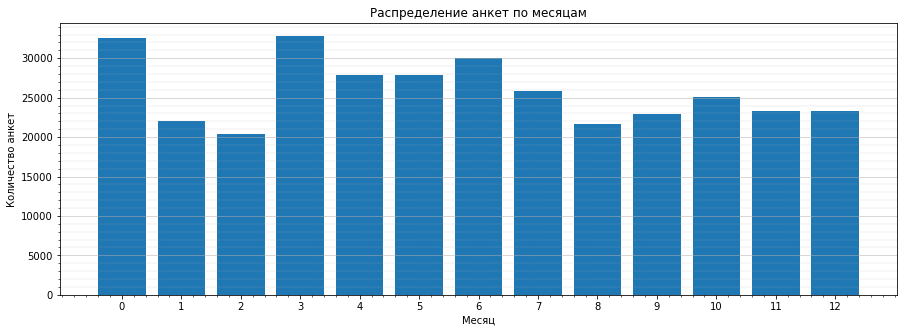

In [22]:
inform_dataset = data['registration_month'].value_counts().sort_index().reset_index()
inform_dataset.columns = ['month', 'count']

plot_distribution(inform_dataset['month'], inform_dataset['count'],
                  'Месяц', 'Количество анкет', 'Распределение анкет по месяцам')

В признаке 'registration_month' мы наблюдаем 13 уникальных значений, что может говорить о том, что значение признака 0 является обозначением пропуска данных в анкете. Если исключить значение 0, то мы можем наблюдать самое большое количество анкет в марте. А мы знаем что конец временного периода нашей выборки датировано началом апреля. Посмотрим в какие года присутствовало значение 0 в признаке:

In [23]:
np.sort(data.loc[data['registration_month'] == 0, 'registration_year'].unique())

array([1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016], dtype=int64)

Значение 0 в признаке 'registration_month' присутствует во все года, поэтому мы не можем однозначно утверждать, что это значение является обозначением пропуска данных. Но поскольку признак 'registration_month' не влияет на ценообразование, а следовательно подлежит удалению, обрежем наш датафрейм по март 2016 г. включительно следующим образом:

In [24]:
# Заменим значение 0 в 'registration_month' на 1 (нас интересует только 3-й месяц)
data['registration_month'] = data['registration_month'].replace(0, 1)

# Сгрупируем признаки 'registration_month' и 'registration_year' в новый признак 'registration_date'
data['registration_date'] = (pd.to_datetime(data['registration_year'].astype(str) +
                                            '-' + data['registration_month'].astype(str) + '-1', errors='coerce'))
# Обрежем датафрейм по март 2016 г.
data = data[data['registration_date'] <= '2016-03-31']

# Удалим 'registration_month' и 'registration_date'
data.drop(columns=['registration_month',
          'registration_date'], axis=1, inplace=True)

Посмотрим на результат через распределение по годам:

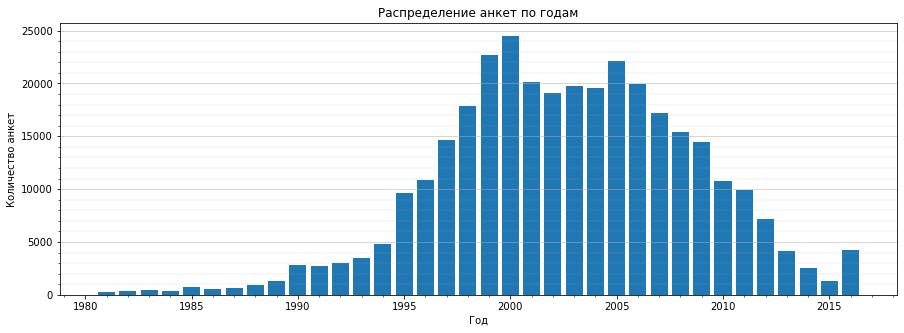

In [25]:
inform_dataset = data['registration_year'].value_counts().sort_index().reset_index()
inform_dataset.columns = ['year', 'count']

plot_distribution(inform_dataset['year'], inform_dataset['count'],
                  'Год', 'Количество анкет', 'Распределение анкет по годам')

Посмотрим сколько мы отрезали от основного датафрейма:

In [26]:
f'Удалено {original_size[0] - data.shape[0]} строк, \
что составляет {1-data.shape[0] / original_size[0]:.2%} от изначального датафрейма'

'Удалено 23936 строк, что составляет 6.75% от изначального датафрейма'

6,75% - вполне приемлемо, учитывая что мы избавились от анкет с аномальными значениями даты регистрации автомобиля.

#### Признак 'postal_code' (почтовый индекс владельца анкеты (пользователя)

Почтовый индекс влияет на ценообразование, так как содержит информацию о географическом расположении продавца автомобиля. Цены на автомобили связаны с географическим местом нахождения, так как разные регионы имеют разный уровень достатка населения, что непосредственно влияет на цены, особенно на вторичном рынке.

Посмотрим на количество уникальных значений признака 'postal_code' после удаления аномальных значений в датах регистрации автомобилей:

In [27]:
print('Количество уникальных значений:', len(data['postal_code'].unique()))
print('Разрядность индексов:', data['postal_code'].astype(str).str.len().value_counts().index)

Количество уникальных значений: 8134
Разрядность индексов: Int64Index([5, 4], dtype='int64')


Не смотря на тип данных int64, признак категориальный. 

[Немного исследовав интернет](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D1%87%D1%82%D0%BE%D0%B2%D1%8B%D0%B5_%D0%B8%D0%BD%D0%B4%D0%B5%D0%BA%D1%81%D1%8B_%D0%B2_%D0%93%D0%B5%D1%80%D0%BC%D0%B0%D0%BD%D0%B8%D0%B8#:~:text=%D0%A1%D0%BE%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B9%20PLZ%2D%D0%B8%D0%BD%D0%B4%D0%B5%D0%BA%D1%81,%D0%B2%D1%81%D0%B5%2010%20%D1%80%D0%B5%D0%B3%D0%B8%D0%BE%D0%BD%D0%BE%D0%B2.), приходим к выводу что в нашем признаке представлены почтовые адреса Германии. 

Также мы можем заметить, что все значения нашего признака, это либо 4-х, либо 5 разрядные числа. Это вызвано потерей нуля спереди индекса. Вот краткая сводка по системе почтовых индексов Германии:

Современная система почтовых индексов Германии (нем. Postleitzahl, сокращённо — PLZ) предусматривает деление территории страны на десять главных почтовых зон и использование пятизначных цифровых кодов. Современный PLZ-индекс состоит из пяти цифр. Первая (крайняя левая) цифра в PLZ-коде обозначает зону (Zone) и, соответственно, аэропорт, через который происходит обмен почтой с этой зоной. При этом следует понимать, что зональное деление PLZ-кодов не соответствует административному делению Германии на земли. Вторая цифра в PLZ-коде обозначает регион зоны и вместе с номером зоны образует двузначный номер региона, который определяет дальнейшую маршрутизацию почты внутри зоны. Регионы внутри зоны, как правило, нумеруются последовательным обходом зоны против часовой стрелки, начиная с юга зоны.

Заменим индексы на почтовые зоны от 0 до 9:

In [28]:
# Создадим функцию:
def replace_index(index):
    if len(index) == 4:
        index = '0'
    return int(index[0])
# Произведем замену:    
data['postal_code'] = data['postal_code'].apply(lambda x: replace_index(str(x)))
# Проверим:
print('Уникальные значения:', np.sort(data['postal_code'].unique()))

Уникальные значения: [0 1 2 3 4 5 6 7 8 9]


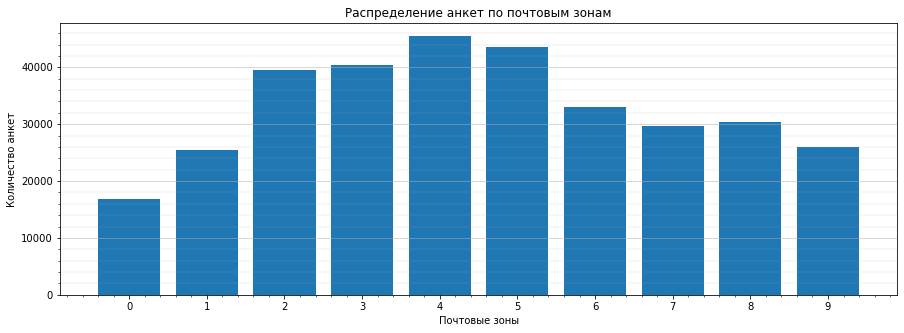

In [29]:
inform_dataset = data['postal_code'].value_counts().sort_index().reset_index()
inform_dataset.columns = ['postal_code', 'count']

plot_distribution(inform_dataset['postal_code'], inform_dataset['count'],
                  'Почтовые зоны', 'Количество анкет', 'Распределение анкет по почтовым зонам')

Из графика распределения мы можем увидеть, что большинство объявлений о продаже машин поданы в зонах 2, 3, 4, 5. [Если посмотреть на карту деления Германии по почтовым зонам](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D1%87%D1%82%D0%BE%D0%B2%D1%8B%D0%B5_%D0%B8%D0%BD%D0%B4%D0%B5%D0%BA%D1%81%D1%8B_%D0%B2_%D0%93%D0%B5%D1%80%D0%BC%D0%B0%D0%BD%D0%B8%D0%B8#/media/%D0%A4%D0%B0%D0%B9%D0%BB:German_postcode_information.png), то мы увидим, что это западные территории Германии. Это вызванно спецификой развития государства - исторически западные районы более развиты.

In [30]:
data = data.drop(['postal_code'], axis=1)

#### Признак 'brand' (марка автомобиля)

В признаке 'brand' содержется 40 уникальных значений, пропущенные данные отсутствуют.

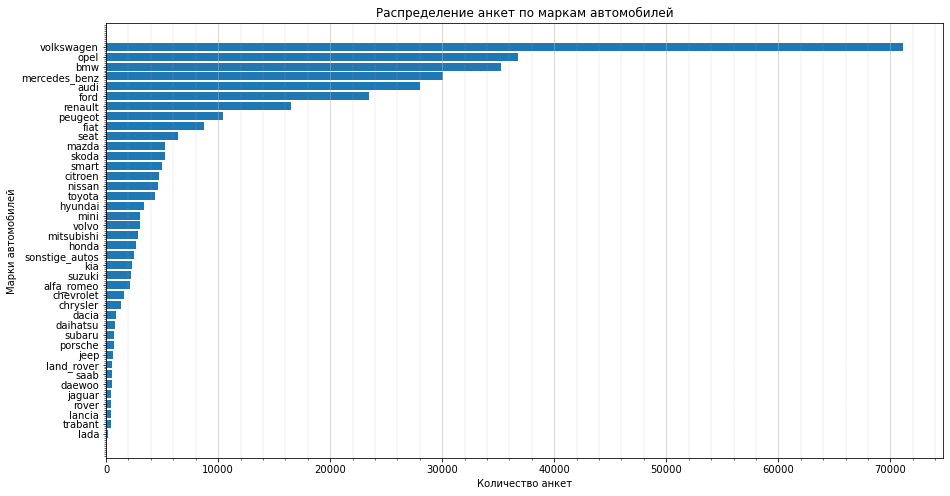

In [31]:
inform_dataset = data['brand'].value_counts().sort_index().reset_index()
inform_dataset.columns = ['brand', 'count']
inform_dataset = inform_dataset.sort_values('count')
plot_distribution(inform_dataset['brand'], inform_dataset['count'],
                  'Количество анкет', 'Марки автомобилей', 'Распределение анкет по маркам автомобилей', h=True)

In [32]:
display(inform_dataset.sort_values('count', ascending=False).head(10))

,brand,count
38,volkswagen,71146
24,opel,36788
2,bmw,35275
20,mercedes_benz,30100
1,audi,28056
10,ford,23434
27,renault,16527
25,peugeot,10430
9,fiat,8782
30,seat,6392


Из диаграммы мы видим, что клиенты сервиса "Не бит, не крашен" предпочитают немецкие автомобили. Все немецкие марки, кроме audi (28056 анкет) приодолели порог в  30000 анкет. На них стоит соредоточить основное внимание маркетологов сервиса "Не бит, не крашен".

#### Признак 'model'  (модель автомобиля)

In [33]:
print('Количество уникальных значений:', len(data['model'].unique()))
print('Количество пропущеных значений:', data['model'].isnull().sum())

Количество уникальных значений: 249
Количество пропущеных значений: 15953


Вот и дошли до пропущенных значений. Посмотрим как распределены пропуски по маркам автомобилей:

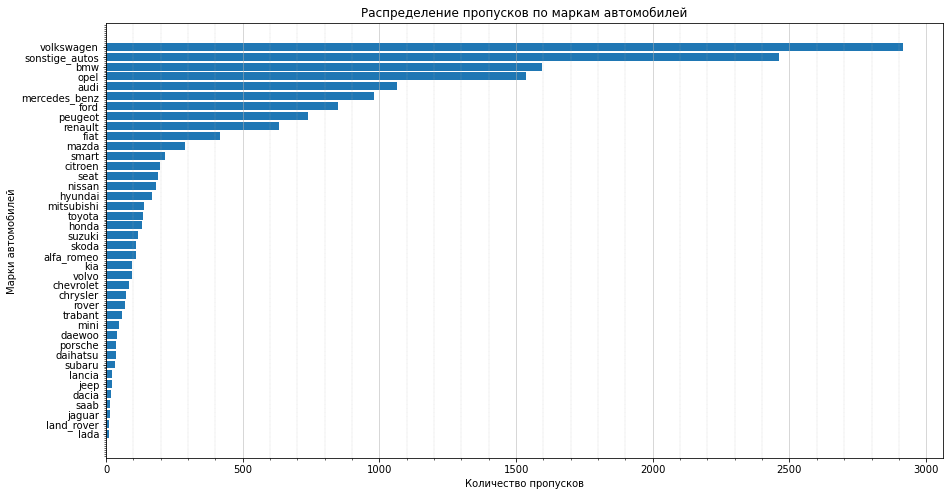

In [34]:
nan_dataset = (
    data.groupby('brand')['model']
    .apply(lambda x: x.isna().sum())
    .reset_index(name='nans')
    .sort_values('nans')
)
plot_distribution(nan_dataset['brand'], nan_dataset['nans'],
                  'Количество пропусков', 'Марки автомобилей', 'Распределение пропусков по маркам автомобилей', h=True)

Из диаграммы мы видим, что пропущенные значения распределены по маркам автомобилей практичеки пропорционально распредению анкет по маркам автомобилей. В глаза бросается sonstige_autos, но в переводе с немецкого, это другие автомобили.

In [35]:
display(data.groupby('brand')['model'].count().nsmallest(3))

brand
sonstige_autos      0
lada              175
trabant           355
Name: model, dtype: int64

Удалим sonstige_autos - мы не знаем ни марку ни модель.

In [36]:
data = data[data['brand'] != 'sonstige_autos']

Остальные пропуски в 'model' заполним заглушкой, так как достоверно узнать их природу мы не можем.

In [37]:
data['model'] = data['model'].fillna('unknown')
# Проверим:
print('Количество пропущеных значений:', data['model'].isnull().sum())

Количество пропущеных значений: 0


#### Признаки 'vehicle_type'  (тип автомобильного кузова), 'gearbox' (тип коробки передач), fuel_type (тип топлива)

Все три признака относятся к техническим характеристикам автомобиля и являются категориальными. 
Посмотрим на них:

In [38]:
tech_features = ['vehicle_type', 'gearbox', 'fuel_type']

for feature in tech_features:
    unique_values = len(data[feature].unique())
    missing_values = data[feature].isnull().sum()
    notnull_values = data[feature].notnull().sum()

    print(f"Для признака '{feature}':")
    print(f"Количество уникальных значений: {unique_values}")
    print(f"Количество пропущенных значений: {missing_values} что составляет \
{missing_values / notnull_values:.2%} от количества значений")
    print()

Для признака 'vehicle_type':
Количество уникальных значений: 9
Количество пропущенных значений: 16189 что составляет 5.19% от количества значений

Для признака 'gearbox':
Количество уникальных значений: 3
Количество пропущенных значений: 15677 что составляет 5.02% от количества значений

Для признака 'fuel_type':
Количество уникальных значений: 8
Количество пропущенных значений: 23366 что составляет 7.67% от количества значений



Посмотрим на количество пропущенных значений, которые присутвуют во всех трех признаках:

In [39]:
data[(data['vehicle_type'].isnull()) & (data['gearbox'].isnull()) & (data['fuel_type'].isnull())].shape[0]

4753

Эти анкеты врядли будут нам полезны при обучении модели - удалим их, а остальные пропуски заполним заглушкой.

In [40]:
# Удаляем:
data.dropna(subset=['vehicle_type', 'gearbox', 'fuel_type'], how='all', inplace=True)
# Заполняем остальные признаки заглушкой и проверяем:
for feature in tech_features:
    data[feature] = data[feature].fillna('unknown')
    missing_values = data[feature].isnull().sum()
    print(f"Для признака '{feature}':")
    print(f"Количество пропущенных значений: {missing_values}")
    print()

Для признака 'vehicle_type':
Количество пропущенных значений: 0

Для признака 'gearbox':
Количество пропущенных значений: 0

Для признака 'fuel_type':
Количество пропущенных значений: 0



Посмотрим, насколько уменьшилась выборка:

In [41]:
(f'Удалено {original_size[0] - data.shape[0]} строк, '
    f'что составляет {1-data.shape[0] / original_size[0]:.2%} от изначального датафрейма')

'Удалено 31152 строк, что составляет 8.79% от изначального датафрейма'

Пока все идет в пределах нормы. Продолжаем.

#### Признак 'repaired' (была машина в ремонте или нет)

Это категориальный признак, содержащий в 2 значения с большим количеством пропусков. Посмотрим на него:

In [42]:
print(f"Количество пропущенных значений: {data['repaired'].isnull().sum()} что составляет \
{data['repaired'].isnull().sum() / data['repaired'].notnull().sum():.2%} от количества значений")

Количество пропущенных значений: 55740 что составляет 20.84% от количества значений


20.84% очень много для удаления, да и признак влияет на ценообразование - мы не можем удалить его. Скорее всего многие клиенты не указывают была ли машина в ремонте, чтобы не потерять в деньгах. Поэтому тоже заполним заглушкой.

In [43]:
data['repaired'] = data['repaired'].fillna('unknown')
# Проверим:
print('Количество пропущеных значений:', data['repaired'].isnull().sum())

Количество пропущеных значений: 0


#### Признак 'power' (мощность (л. с.))

Это важный числовой признак, влияющий на ценообразование. Посмотрим на него:

In [44]:
print('Количество уникальных значений:', len(data['power'].unique()))

Количество уникальных значений: 682


In [45]:
data['power'].describe()

count    323217.000000
mean        113.395307
std         182.031438
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Статистические данные показали разброс от 0 до 20000 л.с. Посмотрим минимальные и максимальные значения:

In [46]:
data['power'].value_counts().sort_index()

0        28612
1           20
2            7
3            1
4            6
         ...  
17932        1
19208        1
19211        1
19312        1
20000        1
Name: power, Length: 682, dtype: int64

Очень много нулей и значения больше 600 л.с явно аномальны. Посмотрим распределение на графике: 

In [47]:
def get_boxplot(data, title, xlim):
    """
    Функция отрисовывает ящик с усами.
    title: заголовок графика.
    xlim: диапазон значений на оси x.
    """
    plt.figure(figsize=(15, 6))
    sns.boxplot(x=data)
    plt.title(title)
    plt.xlim(xlim)
    plt.minorticks_on()
    plt.grid(which='major', linewidth=.5)
    plt.grid(which='minor', linewidth=.25, linestyle='--')
    plt.show()

Зададим для диаграммы размаха диапазон значений по 1500 л.с., потому что выше точно аномальные значения и будем отрезать.

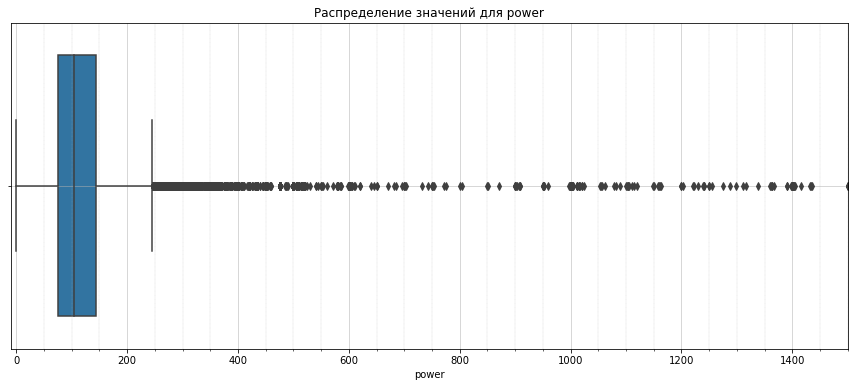

In [48]:
get_boxplot(data['power'], 'Распределение значений для power', (-10, 1500))

Из представленых в выборке моделей автомобилей, [самым маломощным оказался Fiat Nuova 500 (1957—1975), мощность двигателя- 13 л.с.](https://auto.ru/catalog/cars/fiat/500/specifications/harakteristiki-dvigatelya/#:~:text=Fiat%20500%20%D0%BE%D1%81%D0%BD%D0%B0%D1%89%D1%91%D0%BD,102%2D250%20%D0%9D%D0%BC.), [самым мощным автомобилем может быть Ford Mustang Shelby GT500 (2007-2014), мощность двигателя - 662 л.с.](https://ru.wikipedia.org/wiki/Shelby_Mustang#:~:text=V8%2C%20%D0%B1%D0%B5%D0%BD%D0%B7%D0%B8%D0%BD%D0%BE%D0%B2%D1%8B%D0%B9%20%D0%B8%D0%BD%D0%B6%D0%B5%D0%BA%D1%82%D0%BE%D1%80%20%D1%81%20%D1%82%D1%83%D1%80%D0%B1%D0%BE%D0%BD%D0%B0%D0%B4%D0%B4%D1%83%D0%B2%D0%BE%D0%BC%20%D0%B8%20%D0%BF%D1%80%D0%BE%D0%BC%D0%B5%D0%B6%D1%83%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%BC%20%D0%BE%D1%85%D0%BB%D0%B0%D0%B6%D0%B4%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC%20(5800%20%D1%81%D0%BC%C2%B3%2C%20662%20%D0%BB.%20%D1%81.)%2C%20%D1%80%D0%B0%D1%81%D0%BF%D0%BE%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%20%D1%81%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B8%2C%20%D0%BF%D1%80%D0%BE%D0%B4%D0%BE%D0%BB%D1%8C%D0%BD%D0%BE). По этим данным и будем резать нашу выборку.

In [49]:
data = data[(data['power'] >= 13) & (data['power'] <= 662)]

Посмотрим, что получилось:

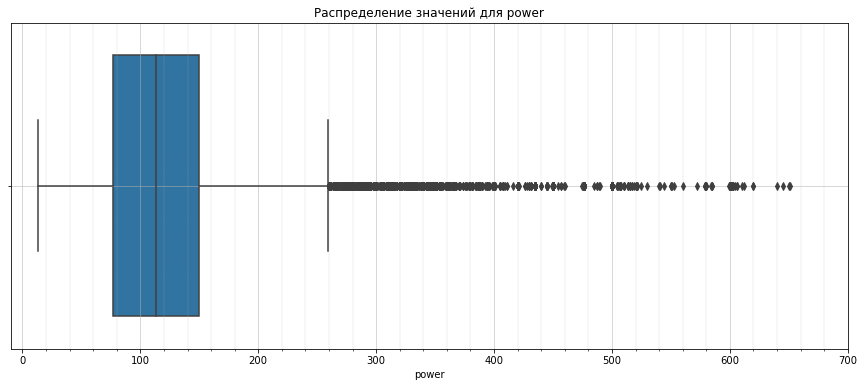

In [50]:
get_boxplot(data['power'], 'Распределение значений для power', (-10, 700))

Из диаграммы мы видим изменения в лучшую сторону. Хвост справа бросается в глаза, но наличие редких мощных серийных автомобилей его оправдывает. Оставим как есть.

Посмотрим, насколько уменьшилась выборка:

In [51]:
(f'Удалено {original_size[0] - data.shape[0]} строк, '
    f'что составляет {1-data.shape[0] / original_size[0]:.2%} от изначального датафрейма')

'Удалено 60168 строк, что составляет 16.98% от изначального датафрейма'

Много, но мы избавились от аномальных значений в мощности двигателя, которые могут мешать обучению модели.

#### Признак 'kilometer'  (пробег (км))

Важный числовой признак с малым количеством уникальных значений. Есть вероятность, что это категориальный признак. Посмотрим на него:

In [52]:
data['kilometer'].value_counts().sort_index()

5000        2767
10000        869
20000       3149
30000       3792
40000       4392
50000       5511
60000       6643
70000       7584
80000       8838
90000      10138
100000     12470
125000     31493
150000    196555
Name: kilometer, dtype: int64

In [53]:
def get_histplot(data, xlabel, rotation=0, kde=True):
    """
    Функция строит seaborn-гистограмму с kde-линией
    data: данные, для которых нужно построить гистограмму.
    xlabel: подпись оси x на графике.
    rotation (по умолчанию 0): угол поворота подписей на оси x.
    kde (по умолчанию False): флаг, указывающий, нужно ли отрисовывать линию ядерной оценки плотности.
    """
    plt.figure(figsize=(15,5))
    sns.histplot(data, kde=kde, linewidth=5, ec='#0073bb')
    plt.xlabel(xlabel)
    plt.ylabel('Количество анкет')
    plt.title(f'Распределение значений для {data.name}')
    plt.xticks(rotation=rotation)
    plt.minorticks_on()
    plt.grid(which='major', linewidth=.5)
    plt.grid(which='minor', linewidth=.25, linestyle='--')
    plt.show()

Посмотрим на распределение:

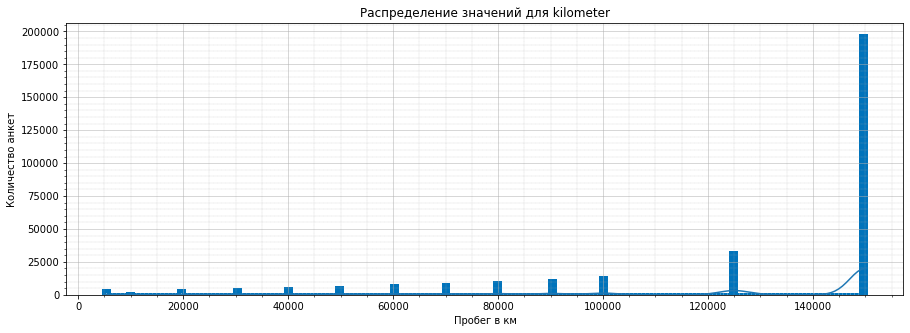

In [54]:
get_histplot(data['kilometer'], 'Пробег в км')

Диаграмма показвает нам, что признак категориальный. Большинство анкет (практически 200000) с пробегом 150000 км., что говорит об аккуратности немецкого автовладельца. Для проверки адекватности заполнения признака, посмотрим на его зависимость от цены на автомобили:

In [55]:
def get_lineplot(data, column_1, column_2, xlabel, ylabel):
    """
    Функция строит линнейный график зависимости признаков
    data: DataFrame, содержащий данные для построения графика.
    column_1: признак, который будет использован для оси x на графике.
    column_2: признак, который будет использован для оси y на графике.
    xlabel: подпись для оси x на графике.
    ylabel: подпись для оси y на графике.
    """
    data_mean = data[[column_1, column_2]].groupby(column_1).mean()
    plt.figure(figsize=(15, 5))
    sns.lineplot(x=column_1, y=column_2, data=data_mean, color='#0073bb', linewidth=4)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f'Зависимость {data[column_2].name} от {data[column_1].name}')
    plt.minorticks_on()
    plt.grid(which='major', linewidth=.5)
    plt.grid(which='minor', linewidth=.25, linestyle='--')
    plt.show()

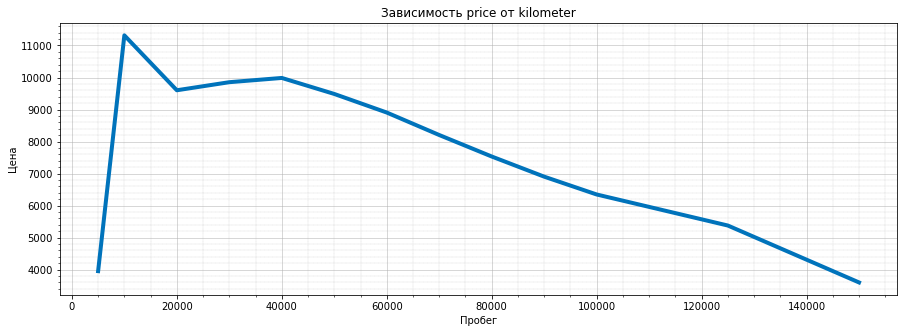

In [56]:
get_lineplot(data, 'kilometer', 'price', 'Пробег', 'Цена')

Чем выше пробег - тем ниже цена. Оставляем признак нетронутым.

#### Целевой признак 'price'(цена (евро))

Это признак, который будем предсказывать. Посмотрим на него:

In [57]:
data['price'].describe()

count    294201.000000
mean       4754.757516
std        4604.992139
min           0.000000
25%        1250.000000
50%        3000.000000
75%        6900.000000
max       20000.000000
Name: price, dtype: float64

Статистические данные показывают нам наличие нулей. Похоже, что клиенты не указали стоимость автомобиля в анкете или произошел какой-то сбой при выгрузке. Посмотрим распределение:

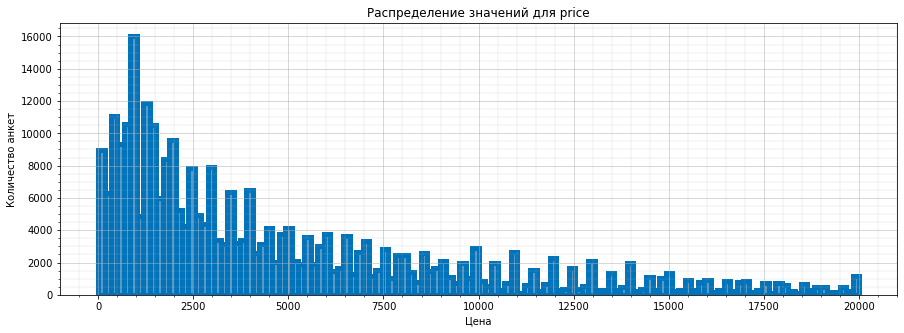

In [58]:
get_histplot(data['price'], 'Цена', kde=False)

Из диаграммы мы видим, что нулей приличное количество. Посмотрим сколько анкет с ценой ниже 100 евро:

In [59]:
(f"Анкет с ценой ниже 100 евро: {data[data['price'] < 100].shape[0]}, "
    f"что составляет {data[data['price'] < 100].shape[0]/data.shape[0]:.2%} от общего количества анкет")

'Анкет с ценой ниже 100 евро: 7024, что составляет 2.39% от общего количества анкет'

Поскольку мы разрабатываем алгоритм, который будет предлагать клиенту цену автомобиля, удалим анкеты ниже 100 евро.

In [60]:
# Удаляем:
data = data[data['price'] >= 100]
# Проверяем:
len(data[data['price'] < 100])

0

#### Посмотрим, что получилось:

Разобрались с признаками, избавились от аномальных и пропущенных значений. Посмотрим, что в итоге:

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287177 entries, 1 to 354364
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              287177 non-null  int64 
 1   vehicle_type       287177 non-null  object
 2   registration_year  287177 non-null  int64 
 3   gearbox            287177 non-null  object
 4   power              287177 non-null  int64 
 5   model              287177 non-null  object
 6   kilometer          287177 non-null  int64 
 7   fuel_type          287177 non-null  object
 8   brand              287177 non-null  object
 9   repaired           287177 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.1+ MB


In [62]:
display(data.head(5))
display(data.tail(5))

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,6000,bus,1995,auto,200,other,150000,petrol,chevrolet,no
3,14250,convertible,2005,manual,163,slk,150000,petrol,mercedes_benz,no
4,5200,convertible,2006,manual,109,2_reihe,80000,petrol,peugeot,no
5,600,small,2005,manual,54,polo,150000,petrol,volkswagen,yes
6,600,small,2005,manual,54,polo,150000,petrol,volkswagen,yes


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
354360,550,small,1997,manual,60,ka,150000,petrol,ford,no
354361,2190,wagon,1998,manual,110,a4,150000,gasoline,audi,no
354362,1890,wagon,2000,manual,150,a4,5000,gasoline,audi,no
354363,15490,convertible,2010,manual,150,c_reihe,125000,gasoline,volvo,no
354364,850,sedan,1991,manual,100,3er,30000,petrol,bmw,no


In [63]:
(f'Удалено {original_size[0] - data.shape[0]} строк, '
    f'что составляет {1-data.shape[0] / original_size[0]:.2%} от изначального датафрейма')

'Удалено 67192 строк, что составляет 18.96% от изначального датафрейма'

Наша выборка "похудела" практически на 19% (67192 строк) и на 5 признаков. Хочется заменить признак 'registration_year' (год регистрации автомобиля) на возраст автомобиля. Так и поступим.

In [64]:
# Создаем новый признак 'car_age' (возраст автомобиля):
data['car_age'] = 2016 - data['registration_year']
# Удаляем признак 'registration_year':
data.drop(columns='registration_year', axis=1, inplace=True)
# Проверим:
data.head(5)

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,repaired,car_age
1,6000,bus,auto,200,other,150000,petrol,chevrolet,no,21
3,14250,convertible,manual,163,slk,150000,petrol,mercedes_benz,no,11
4,5200,convertible,manual,109,2_reihe,80000,petrol,peugeot,no,10
5,600,small,manual,54,polo,150000,petrol,volkswagen,yes,11
6,600,small,manual,54,polo,150000,petrol,volkswagen,yes,11


### Предварительный вывод:

На этом этапе мы:
- Загрузили и описали наш датафрейм
- Привели названия признаков к snake_case
- Обнаружили и удалили 4 явных дубликата
- Исследовали каждый признак по отдельности:
    - Удалили 6 признаков, которые не влияют на ценообразование
    - Удалили аномальные значения
    - Заменили  признак 'registration_year' (год регистрации автомобиля) на признак 'car_age' (возраст автомобиля)
- Датафрейм уменьнился на 19% (67192 строк) и 5 признаков.
Все готово к обучению моделей

## Обучение моделей

Будем обучать следующие модели:
- LinearRegression
- LGBMRegressor
- CatBoostRegressor
- Ridge
- GradientBoostingRegressor

Подбирать гиперпараметры будем при помощи GridSearchCV

Критериями качества моделей будет:
- метрика RMSE (Root Mean Squared Error)
- время затраченное алгоритмами на обучение моделей и предсказания

### Подготовка к обучению и тестированию  моделей

Разобьем датафрейм на выборки с учетом индексации

In [65]:
X_train, X_test = train_test_split(data, shuffle=False, test_size=.25)

X_train = X_train.sample(frac=1, random_state=RANDOM_STATE)
X_test = X_test.sample(frac=1, random_state=RANDOM_STATE)

y_train = X_train['price']
X_train.drop('price', axis=1, inplace=True)

y_test = X_test['price']
X_test.drop('price', axis=1, inplace=True)

Проверим разбиение:

In [66]:
print(f'Количество строк и столбцов в обучающей выборке: {X_train.shape}, '
 f'что составляет {round(len(X_train)/len(data)*100, 2)} % от данных.')
print(f'Количество строк и столбцов в тестовой выборке: {X_test.shape}, '
 f'что составляет {round(len(X_test)/len(data)*100, 2)} % от данных.')

Количество строк и столбцов в обучающей выборке: (215382, 9), что составляет 75.0 % от данных.
Количество строк и столбцов в тестовой выборке: (71795, 9), что составляет 25.0 % от данных.


Объявим списки с числовыми и категориальными признаками:

In [67]:
cat_features = ['vehicle_type', 'gearbox', 'model',
                'kilometer', 'fuel_type', 'brand', 'repaired']
num_features = ['power', 'car_age']

Создаем pipeline с ColumnTransformer, TargetEncoder, StandardScaler

In [68]:
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('encoder', TargetEncoder(cols=cat_features))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num_features', num_transformer, num_features),
        ('cat_features', cat_transformer, cat_features)
    ])

Преобразуем время в секундах в строку в формате "часы:минуты:секунды".

In [69]:
format_time = lambda x: time.strftime('%H:%M:%S', time.gmtime(x))

Создадим таблицу с результатами обучения моделей

In [70]:
result_table = pd.DataFrame(columns=['Название модели', 'Лучшие гиперпараметры',
                            'RMSE', 'Время подбора гиперпараметров', 'Время обучения', 'Время предсказания'])

Напишем функцию, которая будет тестировать модели и возвращать результаты и экземпляр Pipeline с лучшими параметрами

In [71]:
def test_model(pipeline, param_grid):
    """
    Функция test_model выполняет оценку и тестирование модели машинного обучения с использованием метода 
    кросс-валидации и поиска оптимальных гиперпараметров. Она принимает два аргумента:
    pipeline: объект pipeline, содержащий последовательность шагов обработки данных и модель для обучения. 
    Модель должна быть доступна через ключ 'regressor' в named_steps атрибуте pipeline.
    param_grid: словарь с набором гиперпараметров для перебора во время поиска оптимальных значений.
    """
    # Получаем название модели из pipeline
    model_name = pipeline.named_steps['regressor'].__class__.__name__

    # Создаем объект GridSearchCV для текущей модели
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3,
                               scoring='neg_root_mean_squared_error',
                               refit=False, error_score='raise', verbose=10, n_jobs=-1)

    # Обучаем модель на тренировочных данных
    time_grid = time.time()
    grid_search.fit(X_train, y_train)
    time_grid = format_time(time.time() - time_grid)

    # Получаем лучшие параметры и создаем новый экземпляр Pipeline с лучшими параметрами
    best_params = grid_search.best_params_
    pipeline.set_params(**best_params)

    # Обучаем модель с лучшими параметрами
    time_fit = time.time()
    pipeline.fit(X_train, y_train)
    time_fit = format_time(time.time() - time_fit)

    # Предсказываем
    time_predict = time.time()
    predictions = pipeline.predict(X_train)
    RMSE = mean_squared_error(y_train, predictions, squared=False)
    time_predict = format_time(time.time() - time_predict)

    # Сохраняем результаты кросс-валидации для текущей модели
    result = {'Название модели': model_name,
              'Лучшие гиперпараметры': str(best_params),
              'RMSE': round(RMSE, 2),
              'Время подбора гиперпараметров': time_grid,
              'Время обучения': time_fit,
              'Время предсказания': time_predict}

    return result, pipeline, best_params

### LinearRegression

In [72]:
# Создаем объект модели
model = LinearRegression()

# Определяем параметры сетки для подбора гиперпараметров
param_grid = {}

# Создаем Pipeline с моделью
pipeline = Pipeline(steps=[
    ('encoder', TargetEncoder(cols=cat_features)),
    ('regressor', model)
])

# Вызываем функцию test_model
lr_result, lr_best_pipeline, lr_best_params = test_model(pipeline, param_grid)

# Выводим результаты
display(lr_result)

# Добавляем результаты в сводную таблицу
result_table = result_table.append(lr_result, ignore_index=True)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


{'Название модели': 'LinearRegression',
 'Лучшие гиперпараметры': '{}',
 'RMSE': 2519.07,
 'Время подбора гиперпараметров': '00:00:06',
 'Время обучения': '00:00:02',
 'Время предсказания': '00:00:00'}

### LGBMRegressor

In [73]:
# Создаем объект модели
model = LGBMRegressor()

# Определяем параметры сетки для подбора гиперпараметров
param_grid = {
    'regressor__learning_rate': [0.1, 0.2],
    'regressor__n_estimators' : range(100, 400, 50),
    'regressor__max_depth' : range(10, 16 , 5)
}

# Создаем Pipeline с моделью
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(random_state=RANDOM_STATE))
])

# Вызываем функцию test_model
lg_result, lg_best_pipeline, lg_best_params = test_model(pipeline, param_grid)

# Выводим результаты
display(lg_result)

# Добавляем результаты в сводную таблицу
result_table = result_table.append(lg_result, ignore_index=True)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


{'Название модели': 'LGBMRegressor',
 'Лучшие гиперпараметры': "{'regressor__learning_rate': 0.2, 'regressor__max_depth': 10, 'regressor__n_estimators': 350}",
 'RMSE': 1357.08,
 'Время подбора гиперпараметров': '00:01:30',
 'Время обучения': '00:00:03',
 'Время предсказания': '00:00:01'}

### CatBoostRegressor

In [74]:
# Создаем объект модели
model = CatBoostRegressor()

# Определяем параметры сетки для подбора гиперпараметров
param_grid = {'regressor__learning_rate': [0.01, 0.1, 0.5], 'regressor__n_estimators': range(100, 301, 100)}

# Создаем Pipeline с моделью
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(random_state=RANDOM_STATE))
])

# Вызываем функцию test_model
cb_result, cb_best_pipeline, cb_best_params = test_model(pipeline, param_grid)

# Выводим результаты
display(cb_result)

# Добавляем результаты в сводную таблицу
result_table = result_table.append(cb_result, ignore_index=True)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
0:	learn: 3161.7284453	total: 158ms	remaining: 47.3s
1:	learn: 2497.4077072	total: 177ms	remaining: 26.3s
2:	learn: 2196.0493630	total: 193ms	remaining: 19.1s
3:	learn: 2031.9260421	total: 208ms	remaining: 15.4s
4:	learn: 1941.3387004	total: 224ms	remaining: 13.2s
5:	learn: 1895.0713560	total: 238ms	remaining: 11.7s
6:	learn: 1869.6171204	total: 252ms	remaining: 10.6s
7:	learn: 1828.8299070	total: 267ms	remaining: 9.73s
8:	learn: 1813.0047564	total: 281ms	remaining: 9.08s
9:	learn: 1799.7535396	total: 295ms	remaining: 8.54s
10:	learn: 1786.7365867	total: 309ms	remaining: 8.12s
11:	learn: 1776.6922848	total: 323ms	remaining: 7.75s
12:	learn: 1760.9571064	total: 336ms	remaining: 7.42s
13:	learn: 1749.2967278	total: 350ms	remaining: 7.16s
14:	learn: 1739.6955914	total: 366ms	remaining: 6.96s
15:	learn: 1730.7408539	total: 382ms	remaining: 6.77s
16:	learn: 1720.2985546	total: 396ms	remaining: 6.59s
17:	learn: 1714.9684196	total: 4

{'Название модели': 'CatBoostRegressor',
 'Лучшие гиперпараметры': "{'regressor__learning_rate': 0.5, 'regressor__n_estimators': 300}",
 'RMSE': 1401.4,
 'Время подбора гиперпараметров': '00:01:09',
 'Время обучения': '00:00:07',
 'Время предсказания': '00:00:00'}

### Ridge

In [75]:
# Создаем объект модели
model = Ridge()

# Определяем параметры сетки для подбора гиперпараметров
param_grid = {'regressor__alpha': [.1, 1, 10]}

# Создаем Pipeline с моделью
pipeline = Pipeline(steps=[
    ('encoder', TargetEncoder(cols=cat_features)),
    ('regressor', Ridge(random_state=RANDOM_STATE))
])

# Вызываем функцию test_model
rg_result, rg_best_pipeline, rg_best_params = test_model(pipeline, param_grid)

# Выводим результаты
display(rg_result)

# Добавляем результаты в сводную таблицу
result_table = result_table.append(rg_result, ignore_index=True)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


{'Название модели': 'Ridge',
 'Лучшие гиперпараметры': "{'regressor__alpha': 0.1}",
 'RMSE': 2519.07,
 'Время подбора гиперпараметров': '00:00:05',
 'Время обучения': '00:00:02',
 'Время предсказания': '00:00:00'}

### GradientBoostingRegressor

In [76]:
# Создаем объект модели
model = GradientBoostingRegressor()

# Определяем параметры сетки для подбора гиперпараметров
param_grid = {
    'regressor__n_estimators': [50, 100, 200, 250, 300],
    'regressor__learning_rate': [.01, .1, 1] 
}

# Создаем Pipeline с моделью
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=RANDOM_STATE))
])

# Вызываем функцию test_model
gb_result, gb_best_pipeline, gb_best_params = test_model(pipeline, param_grid)

# Выводим результаты
display(gb_result)

# Добавляем результаты в сводную таблицу
result_table = result_table.append(gb_result, ignore_index=True)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


{'Название модели': 'GradientBoostingRegressor',
 'Лучшие гиперпараметры': "{'regressor__learning_rate': 1, 'regressor__n_estimators': 300}",
 'RMSE': 1505.27,
 'Время подбора гиперпараметров': '00:06:03',
 'Время обучения': '00:00:58',
 'Время предсказания': '00:00:01'}

### Предварительный вывод

На этом этапе мы обучили и протестировали следующие модели:

- LinearRegression
- LGBMRegressor
- CatBoostRegressor
- Ridge
- GradientBoostingRegressor

Подобрали гиперпараметры при помощи GridSearchCV

По результатам тестирования моделей мы можем утверждать:
- На первом месте по RMSE (1357.08) LGBMRegressor, показавший неплохое время на подбор гиперпараметров и обучение
- На втором месте по RMSE (1401.40)  CatBoostRegressor, также показавший неплохое время
- Остальные модели не отвечают нашим критериям

## Анализ моделей

### Создадим бэггинг из лучших моделей

 Бэггинг (англ. Bagging, от bootstrap aggregating) — это метод ансамблевого обучения, который использует комбинацию нескольких моделей для улучшения предсказательной способности. Основная идея бэггинга заключается в создании нескольких подвыборок из обучающего набора данных, затем каждая подвыборка используется для обучения отдельной модели.

В процессе бэггинга каждая модель обучается независимо от остальных моделей, что делает его параллельным методом обучения. Когда необходимо сделать предсказание, каждая из обученных моделей выдает свой прогноз, а итоговый прогноз получается путем усреднения или голосования по прогнозам всех моделей.

Основное преимущество бэггинга заключается в снижении дисперсии модели, что может приводить к улучшению качества предсказаний и более стабильным результатам. Бэггинг также помогает снизить проблему переобучения, поскольку каждая модель обучается на разных подмножествах данных.

In [77]:
# Создаем базовые модели
catboost = CatBoostRegressor(learning_rate=0.5, n_estimators=300, random_state=RANDOM_STATE)
lgbm = LGBMRegressor(learning_rate=0.2, max_depth=15, n_estimators=350, random_state=RANDOM_STATE)

# Создаем бэггинг-модель, используя базовые модели
bagging = BaggingRegressor(base_estimator=lgbm, n_estimators=6)

# Создаем Pipeline с препроцессором и бэггинг-моделью
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', bagging)
])

# Определяем параметры сетки для подбора гиперпараметров
param_grid = {
    'regressor__base_estimator': [lgbm, catboost],
    'regressor__n_estimators': [5, 6, 7]
}

# Вызываем функцию test_model
bag_result, bag_best_pipeline, bag_best_params = test_model(pipeline, param_grid)

# Выводим результаты
display(bag_result)

# Добавляем результаты в сводную таблицу
result_table = result_table.append(bag_result, ignore_index=True)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


{'Название модели': 'BaggingRegressor',
 'Лучшие гиперпараметры': "{'regressor__base_estimator': LGBMRegressor(learning_rate=0.2, max_depth=15, n_estimators=350,\n              random_state=42), 'regressor__n_estimators': 7}",
 'RMSE': 1350.84,
 'Время подбора гиперпараметров': '00:03:23',
 'Время обучения': '00:00:13',
 'Время предсказания': '00:00:06'}

Посмотрим на сводную таблицу результатов:

In [78]:
result_table

,Название модели,Лучшие гиперпараметры,RMSE,Время подбора гиперпараметров,Время обучения,Время предсказания
0,LinearRegression,{},2519.07,00:00:06,00:00:02,00:00:00
1,LGBMRegressor,"{'regressor__learning_rate': 0.2, 'regressor__max_depth': 10, 'regressor__n_estimators': 350}",1357.08,00:01:30,00:00:03,00:00:01
2,CatBoostRegressor,"{'regressor__learning_rate': 0.5, 'regressor__n_estimators': 300}",1401.40,00:01:09,00:00:07,00:00:00
3,Ridge,{'regressor__alpha': 0.1},2519.07,00:00:05,00:00:02,00:00:00
4,GradientBoostingRegressor,"{'regressor__learning_rate': 1, 'regressor__n_estimators': 300}",1505.27,00:06:03,00:00:58,00:00:01
5,BaggingRegressor,"{'regressor__base_estimator': LGBMRegressor(learning_rate=0.2, max_depth=15, n_estimators=350,\n random_state=42), 'regressor__n_estimators': 7}",1350.84,00:03:23,00:00:13,00:00:06


BaggingRegressor показал незначительно лучше результат чем лидер тестирования на тренировочной выборке LGBMRegressor, но затратил практически в 3 раза больше времени.

### Протестируем нашу лучшую модель на тестовой выборке и сравним с константным предсказанием

Создадим сводную таблицу для финальных результатов

In [79]:
test_result_table = result_table = pd.DataFrame(columns=['Название модели', 'RMSE', 'Время предсказания'])

### Создадим константное предсказание

In [80]:
dummy = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DummyRegressor(strategy="mean"))
])

dummy.fit(X_train, y_train)

# Предсказываем
time_predict = time.time()
predict_dummy = dummy.predict(X_test)
time_predict = format_time(time.time() - time_predict)
RMSE = mean_squared_error(y_test, predict_dummy, squared=False)

dummy_result = {'Название модели': dummy.named_steps['regressor'].__class__.__name__,
              'RMSE': round(RMSE, 2),
              'Время предсказания': time_predict}

# Добавляем результаты в сводную таблицу
test_result_table = test_result_table.append(dummy_result, ignore_index=True)

# Выводим результаты
dummy_result

{'Название модели': 'DummyRegressor',
 'RMSE': 4657.45,
 'Время предсказания': '00:00:00'}

### LGBMRegressor на тестовой выборке

In [81]:
# Предсказываем
time_predict = time.time()
lg_test=lg_best_pipeline.predict(X_test)
RMSE = mean_squared_error(y_test, lg_test, squared=False)
time_predict = format_time(time.time() - time_predict)
lg_result = {'Название модели': lg_best_pipeline.named_steps['regressor'].__class__.__name__,
              'RMSE': round(RMSE, 2),
              'Время предсказания': time_predict}

# Добавляем результаты в сводную таблицу
test_result_table = test_result_table.append(lg_result, ignore_index=True)

# Выводим результаты
lg_result

{'Название модели': 'LGBMRegressor',
 'RMSE': 1499.78,
 'Время предсказания': '00:00:00'}

### Посмотрим на результат

In [82]:
test_result_table

,Название модели,RMSE,Время предсказания
0,DummyRegressor,4657.45,00:00:00
1,LGBMRegressor,1499.78,00:00:00


BaggingRegressor на тестовой выборке показал лучший RMSE и не сильно просел по времени по отношению к остальным моделям.

### Предварительный вывод

На этом этапе мы:

- Построили бэггинг из лучших моделей LGBMRegressor и CatBoostRegressor
- Проанализировали все модели на тренировочной выборке
- Построили константное предсказание на тестовой выборке для сравнения
- Выбрали лучшие модели и построили предсказания на тестовой выборке 
- Создали константное предсказание на тестовой выборке

## Вывод

Работая над проектом мы:
- Загрузили и изучили данные.
- Заполнили пропущенные значения и обработать аномалии в признаках. Удалили неинформативные признаки.
- Подготовили выборки для обучения моделей.
- Обучили модели:
    - линейные: LinearRegression и Ridge
    - бустинги: LGBMRegressor, CatBoostRegressor и GradientBoostingRegressor
- Проанализировали время обучения, время предсказания и качество моделей.
- Лучше всего себя себя показал LGBMRegressor:
    - На тренировочной выборке: RMSE: 1357.08, Время подбора гиперпараметров: 00:01:30, Время обучения: 00:00:03, Время предсказания: 00:00:01
    - На тестовой выборке: RMSE: 1499.78, Время предсказания: 00:00:00

**Опираясь на критерии заказчика, и проверив качество модели на тестовой выборке, мы можем рекомендовать сервису по продаже автомобилей с пробегом «Не бит, не крашен» обученую модель LGBMRegressor с ошибкой предсказания 1510.32 евро. Для сравнения у константной модели ошибка предсказания 4657.45 евро.**